# 1.6 Canvass Inspection Violations

- [1.6.1. Violation Code Monthly Hit Rates](#Violation-Code-Monthly-Hit-Rates)
- [1.6.2. Before and After Model Deployment](#Before-and-After-Model-Deployment)
- [1.6.3. Number of Inspections per Month by Inspector Cluster](#Number-of-Inspections-per-Month-by-Inspector-Cluster)

Code hiding script from [Damian Kao](http://blog.nextgenetics.net/?e=102).

In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
Code hidden for easier reading: <a href="javascript:code_toggle()">toggle on/off.</a>''')

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as stat
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import math

In [3]:
from research.strings import VIOLATIONS, MONTHS

## Load Data

In [4]:
raw = pd.read_csv("data/canvass_records.csv.gz")
print("Read {} records.".format(len(raw)))
df = raw.query("year < 2018")
print("Kept {} records.".format(len(df)))

Read 50462 records.
Kept 47639 records.


In [5]:
print("Date Range: {} to {}".format(df["date_str"].min(), df["date_str"].max()))

Date Range: 2010-01-04 to 2017-12-29


In [6]:
vmat = df[VIOLATIONS].values
vdf = pd.DataFrame()
vdf["Code"] = VIOLATIONS
vdf["Count"] = vmat.sum(axis=0)
vdf["Rate"] = vmat.sum(axis=0) / len(vmat)
vdf["Rank"] = len(VIOLATIONS) - stat.rankdata(vdf["Count"].values).astype(int) + 1
vdf = vdf[["Code", "Count", "Rate", "Rank"]]
vdf.sort_values("Rank").round(3)

,Code,Count,Rate,Rank
2,V3,4418,0.093,1
1,V2,2233,0.047,2
7,V8,1239,0.026,3
11,V12,1012,0.021,4
10,V11,895,0.019,5
5,V6,826,0.017,6
8,V9,307,0.006,7
9,V10,233,0.005,8
3,V4,227,0.005,9
0,V1,219,0.005,10


In [7]:
max_rate = max([df.groupby("month")[v].mean().max() for v in VIOLATIONS])
print("The maximum monthly rate is {0:.3f}.".format(max_rate))

The maximum monthly rate is 0.128.


## Violation Code Monthly Hit Rates

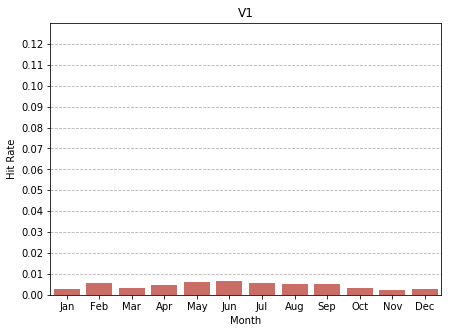

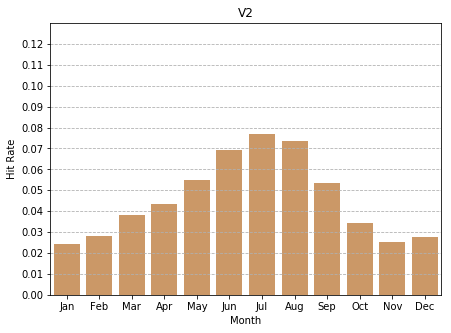

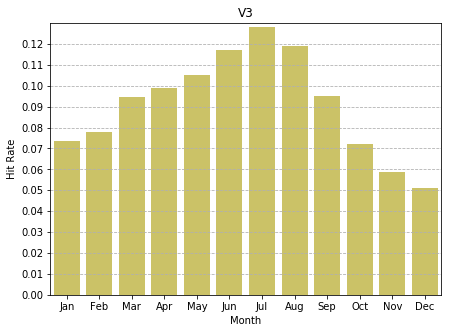

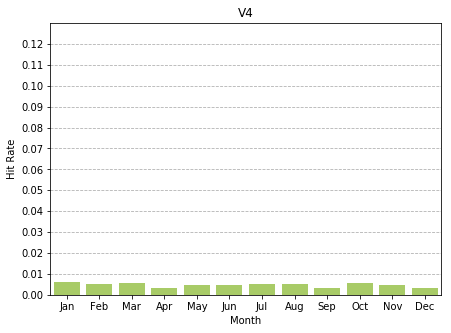

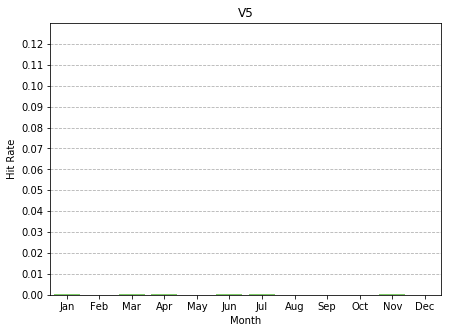

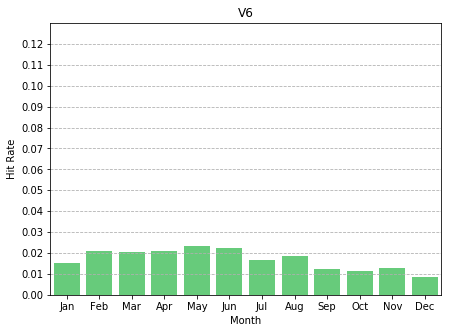

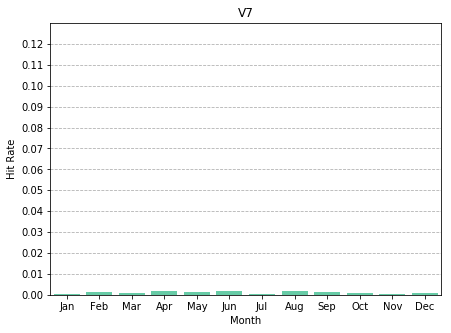

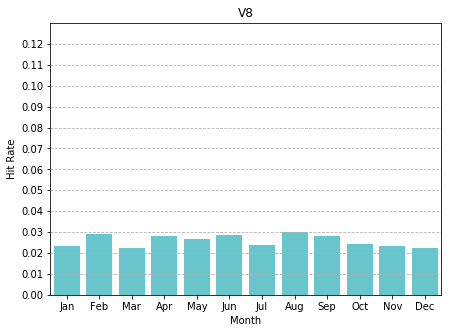

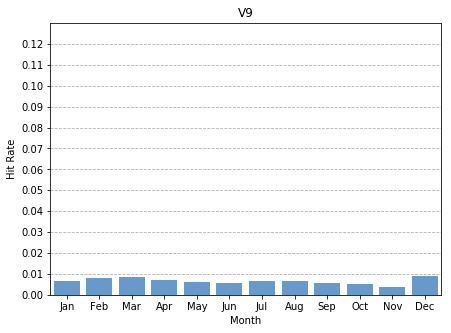

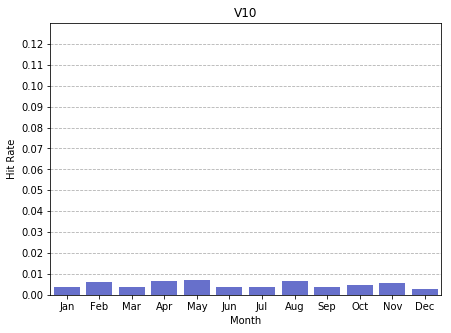

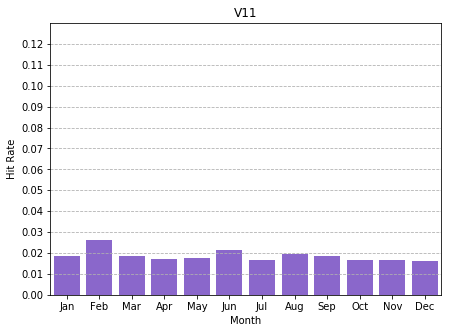

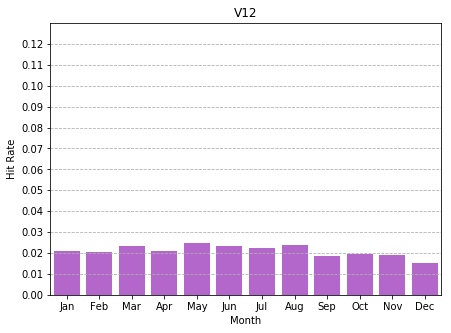

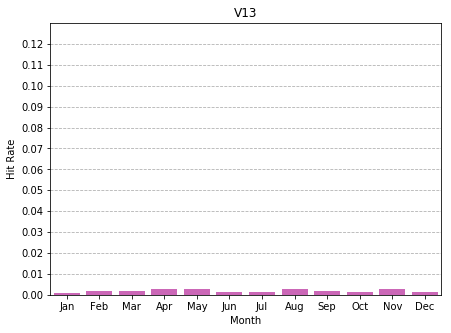

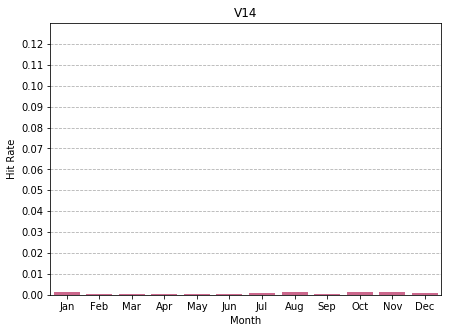

In [8]:
pal = sns.color_palette("hls", len(VIOLATIONS))
for i, (viol, color) in enumerate(zip(VIOLATIONS, pal)):
    table = df.groupby("month")[viol].mean()
    sns.barplot(MONTHS, table.values, color=color)
    plt.ylim(0, 0.13)
    plt.xticks(range(len(MONTHS)), MONTHS)
    plt.yticks(np.arange(0, 0.13, 0.01))
    plt.grid(axis="y", linestyle="--")
    plt.xlabel("Month")
    plt.ylabel("Hit Rate")
    plt.title(viol)
    plt.gcf().set_size_inches(7, 5)
    plt.show()

## Before and After Model Deployment

In [9]:
df_before = df.query("year <= 2014")
df_after = df.query("year > 2014")
name_list = ["Before Model", "After Model"]
df_list = [df_before, df_after]
print("Found {} records before model deployment.".format(len(df_before)))
print("Found {} records after model deployment.".format(len(df_after)))

Found 27277 records before model deployment.
Found 20362 records after model deployment.


In [10]:
both_max_rate = np.max([[df_sub.groupby("month")[v].mean().max() for v in VIOLATIONS] for df_sub in df_list])
print("The maximum monthly rate is {0:.3f}.".format(both_max_rate))

The maximum monthly rate is 0.140.


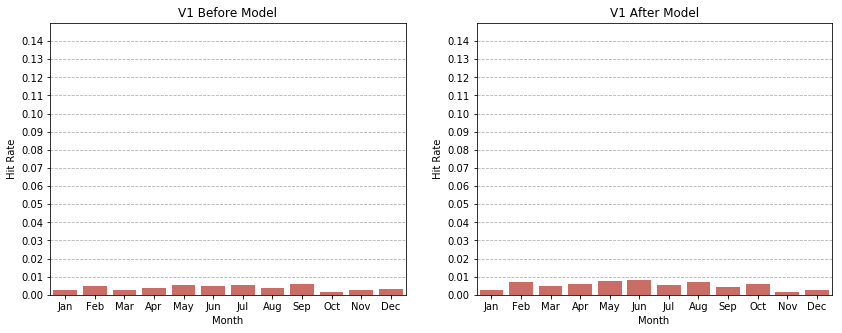

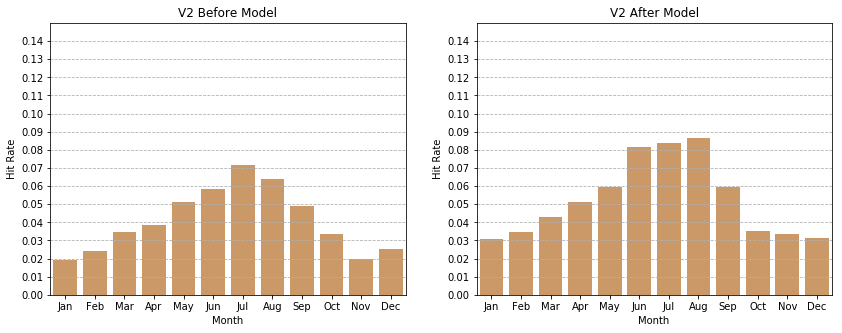

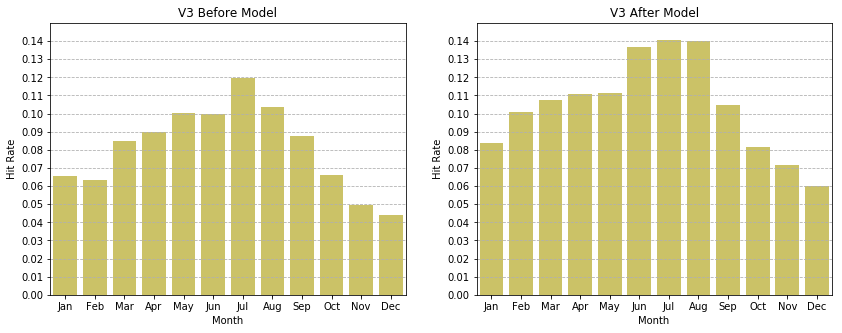

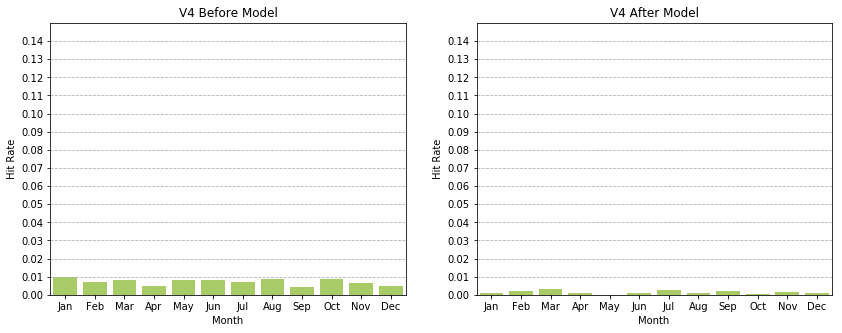

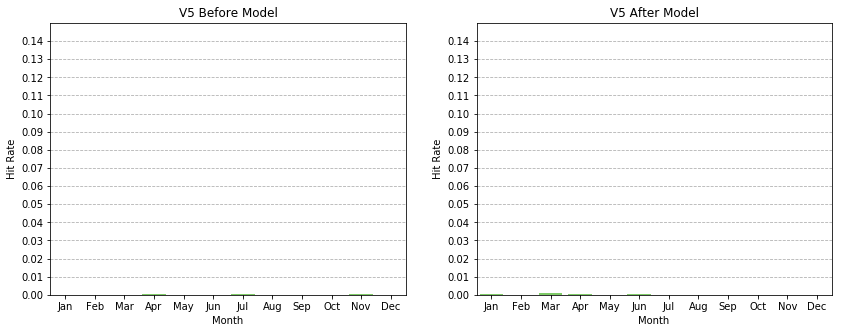

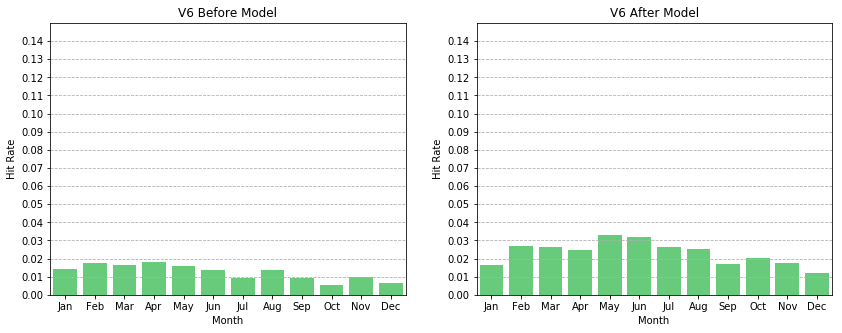

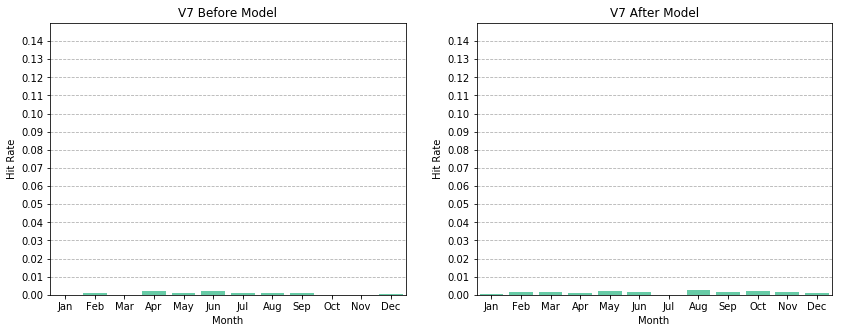

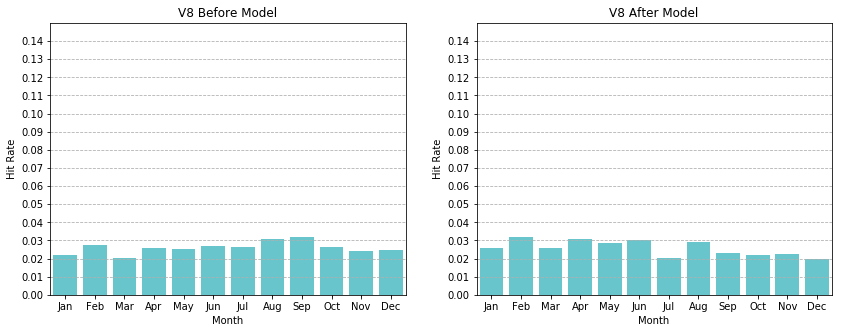

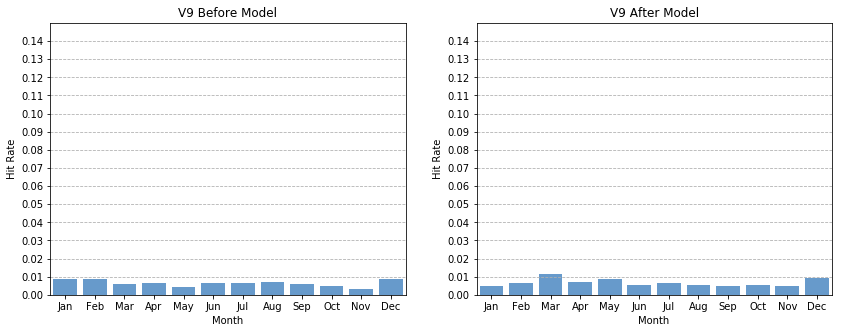

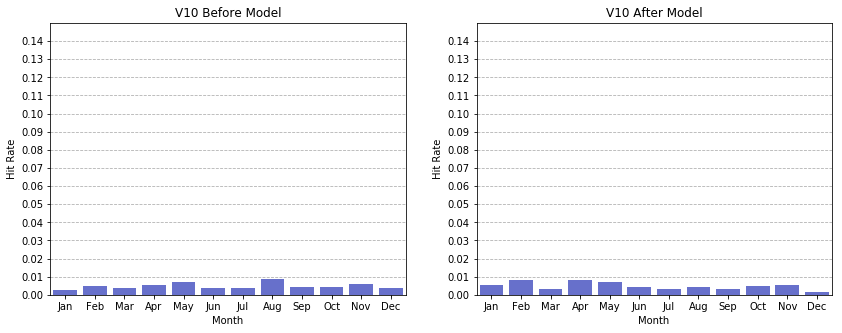

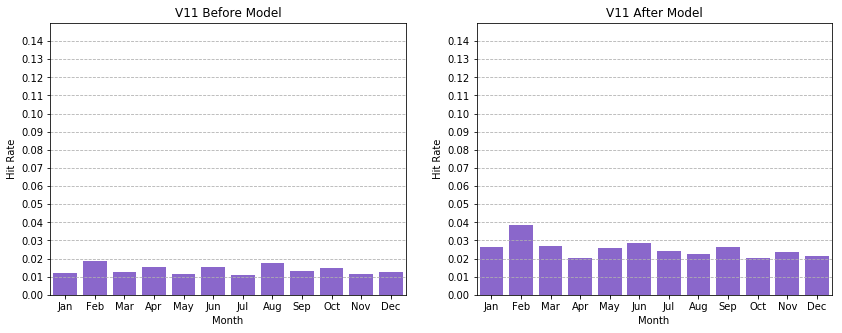

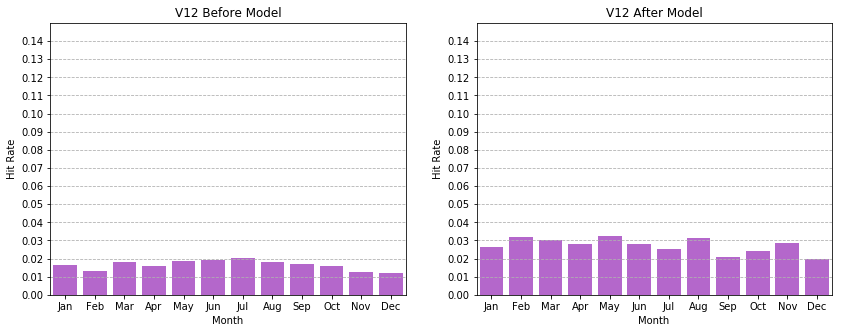

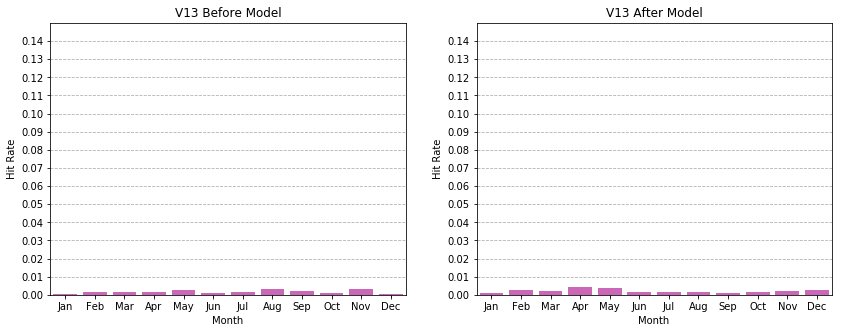

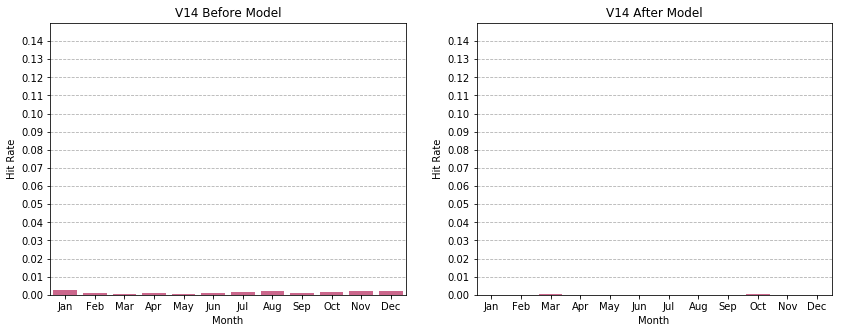

In [11]:
pal = sns.color_palette("hls", len(VIOLATIONS))
for i, (viol, color) in enumerate(zip(VIOLATIONS, pal)):
    fig, axes = plt.subplots(1, 2)
    axes = axes.flatten()
    for name, df_sub, ax in zip(name_list, df_list, axes):
        table = df_sub.groupby("month")[viol].mean()
        sns.barplot(MONTHS, table.values, color=color, ax=ax)
        ax.set_ylim(0, 0.15)
        ax.set_xticks(range(len(MONTHS)), MONTHS)
        ax.set_yticks(np.arange(0, 0.15, 0.01))
        ax.grid(axis="y", linestyle="--")
        ax.set_xlabel("Month")
        ax.set_ylabel("Hit Rate")
        ax.set_title("{} {}".format(viol, name))
    fig.set_size_inches(14, 5)
    plt.show()

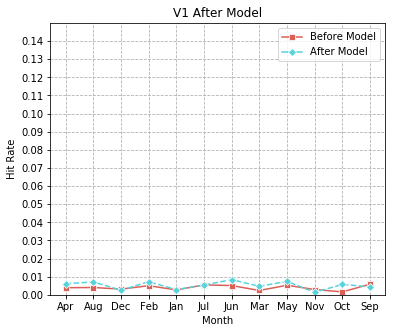

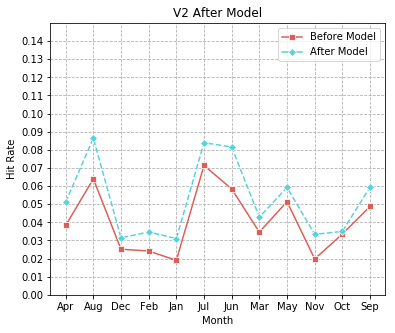

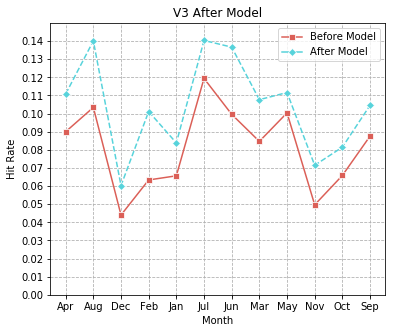

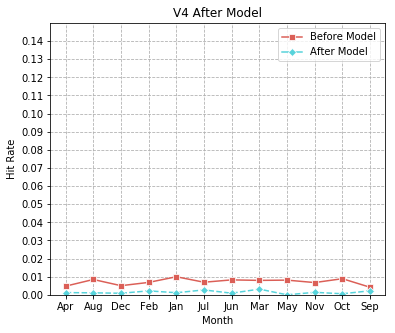

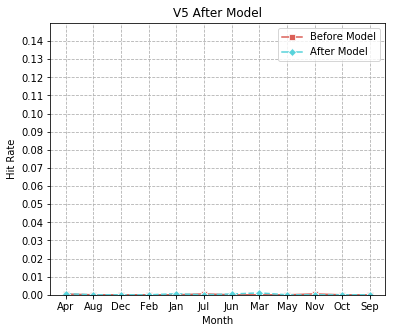

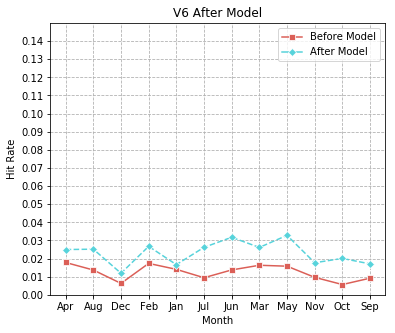

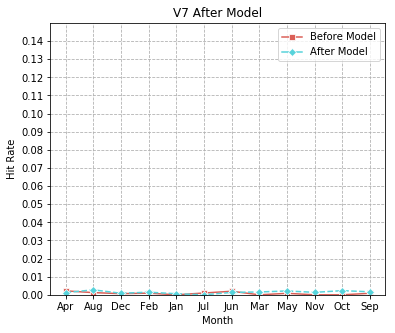

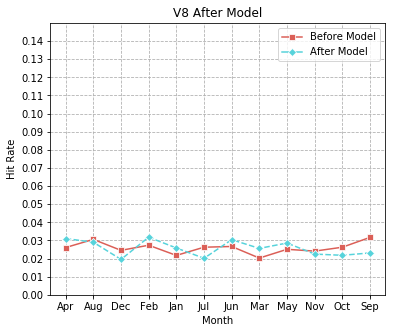

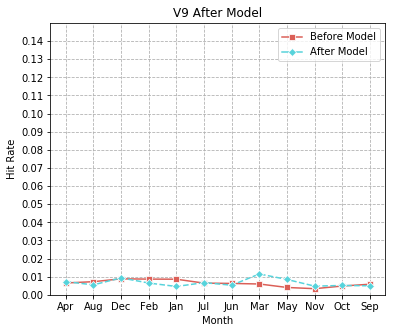

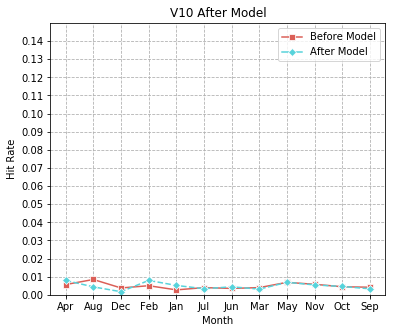

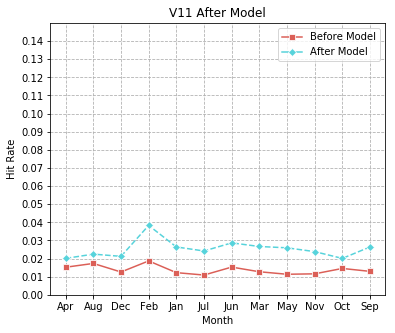

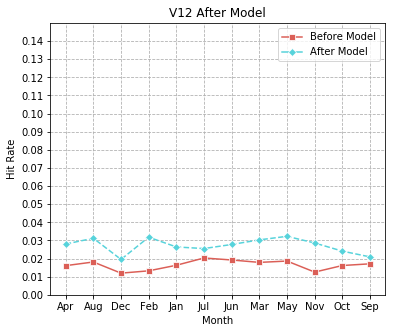

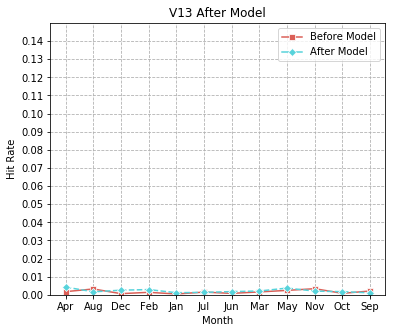

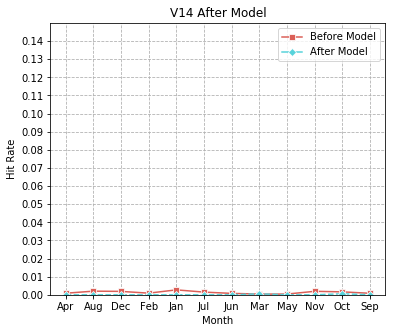

In [43]:
pal = sns.color_palette("hls", 2)
markers = ["s", "D"]
for i, viol in enumerate(VIOLATIONS):
    fig, ax = plt.subplots()
    for name, df_sub, color, mark in zip(name_list, df_list, pal, markers):
        table = df_sub.groupby("month")[viol].mean()
        sns.lineplot(
            MONTHS, table.values, color=color, ax=ax,
            label=name, marker=mark
        )
        ax.set_ylim(0, 0.15)
        ax.set_xticks(range(len(MONTHS)), MONTHS)
        ax.set_yticks(np.arange(0, 0.15, 0.01))
        ax.grid(linestyle="--")
        ax.set_xlabel("Month")
        ax.set_ylabel("Hit Rate")
        ax.set_title("{} {}".format(viol, name))
    ax.lines[1].set_linestyle("--")
    fig.set_size_inches(6, 5)
    plt.show()

## Number of Inspections per Month by Inspector Cluster

In [12]:
from research.strings import INSPECTORS

In [13]:
df_inspecs = pd.read_csv("data/inspections_train.csv")
df_inspecs["month"] = pd.DatetimeIndex(df_inspecs["inspection_date"]).month.values
print("Read {} records.".format(len(df_inspecs)))

Read 17075 records.


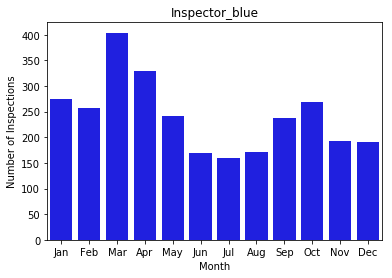

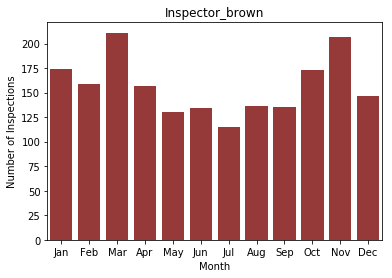

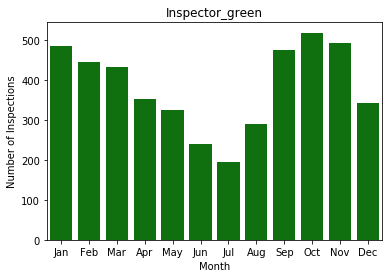

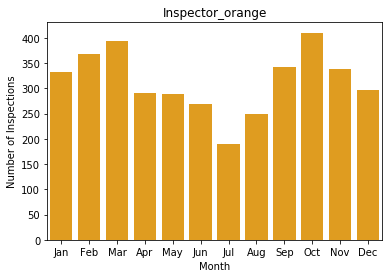

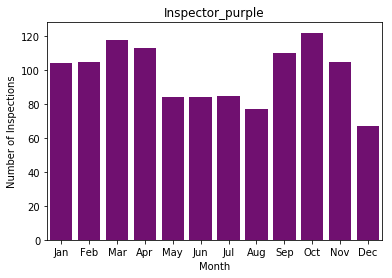

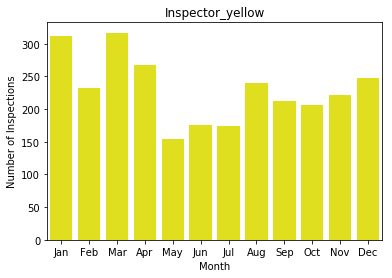

In [14]:
pal = sns.color_palette("hls", len(INSPECTORS))
pal = [name.split("_")[1] for name in INSPECTORS]
for cluster, color in zip(INSPECTORS, pal):
    df_ins = df_inspecs.query("{} > 0".format(cluster))
    table = df_ins.groupby("month")["month"].count()
    sns.barplot(MONTHS, table.values, color=color)
    plt.xlabel("Month")
    plt.ylabel("Number of Inspections")
    plt.title(cluster)
    plt.show()